...because it's coming out of left field at the very last minute, like that one meme, yknow?

anyway

mostly copypasta from make_file_lists and heatmaps, gonna just look at the same AIA images we already used and save new .tiffs of them, only have to transfer those to disco (not full datasets), and just find+replace to fix path names in train_lists

and test_lists actually, don't forget those

In [2]:
import csv
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import sys
import random
import datetime
import traceback
from tqdm import tqdm


In [14]:
#edited 10/13/20 to get a uniform zero level for signed magnetograms
#1/28/21 futzing with conversion specifics- added round before cast to uint8, fixed "uint8 and then also log" for aia, 
#does both the old log10 version of aia and the basic ol' -min, /max*255 
#does hmi abs correctly now, I think? double check
#Do I want to do something more similar to the hmi (with a set offset value) with aia? think about that later
# ^guess what asshole, it's later (6/28 adding clipping for AIA)

def fits_to_tiff(filepath, img_type, r=False, outp_name=None, absval=False, log_10=False):

    name, ext = os.path.splitext(filepath)
    
    if not outp_name:
        outp_name = name.replace(name.split('/')[-2], name.split('/')[-2]+'/tiff') #places new files in separate directory
    
    img = fits.open(filepath)
    img.verify('fix')

    #img.info()

    data = img[1].data #has to be img[1]
    
    if r:
        data=np.rot90(data)
        data=np.rot90(data)
    
    width = data.shape[1]
    height = data.shape[0]
    
    aia_max=2550 
    aia_min=1 #helps with log yelling at me
    hmi_offset=2550
    
    if img_type == 'aia':
        
        data[data<aia_min]=aia_min
        data[data>aia_max]=aia_max
        
        
        
        if log_10:
            data = np.log10(data)
            aia_min=np.log10(aia_min)
            aia_max=np.log10(aia_max)
            #pass
        else:
            pass
        
        
        data=data-aia_min
        data=data.astype(float)/(aia_max-aia_min)*255
        data=np.round(data)
        data=data.astype(np.uint8)
        #print(data)
            
        
    elif img_type == 'hmi':
        if absval:
            data = abs(data)
        
        data[data>hmi_offset]=hmi_offset
        data[data<-hmi_offset]=-hmi_offset
        data=data+hmi_offset
        data=data*255./(2*hmi_offset)
        data=np.round(data)
        data=data.astype(np.uint8)
        
        #else:
            #data = data - data.min()
            
    #data = data.astype(float)/data.max() * 225 #normalize data and multiply by 225 to map to uint8 values
    
    outputArray = np.array(data, dtype=np.uint8)

    output = Image.fromarray(outputArray.reshape((height, width)), "L")

    if not os.path.exists(outp_name + '/' +  name.split('/')[-2]):
        os.makedirs(outp_name + '/' +  name.split('/')[-2])
    
    output.save(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")
    img.close()
    
    return(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff", data.min(), data.max())

In [47]:
mx=0
mn=100000
maxlist=[]
minlist=[]


def fix_aia(trainlist, log_flag, rotate_flag=False):
    new_trainlist=trainlist.replace('/data/', '/data/fixed_aia_lists/')
    trainlist=open(trainlist, 'r')
    
    new_trainlist=open(new_trainlist, 'w')
    w = csv.writer(new_trainlist, delimiter = ',')
    w.writerow(['path_signal', 'path_target'])
    
    for l in tqdm(trainlist.readlines()):
        
        if rotate_flag:
            rotate=np.random.randint(0, 1)
            
        if 'path_signal' in l:
            continue
            
        tiffname=l.split(',')[0].strip()
        try:
            hminame=l.split(',')[1].strip()
        except IndexError:
            continue #when last line got cut off
        tiffdir='/'.join(tiffname.split('/')[:-2])

        fitsname=tiffname.replace(tiffdir, '/mnt/zena/AIA').replace('.tiff', '.fits')

        new_tiffdir=tiffdir.replace('/fs1/project/iip/zenalisa/data/', '/home/zenalisa/data/fixed_aia/')
        new_tiffname=tiffname.replace(tiffdir, new_tiffdir)
        
        #print(new_tiffdir)
        
        a, amin, amax = fits_to_tiff(fitsname, 'aia', r=bool(rotate), outp_name=new_tiffdir, log_10=log_flag)
        if rotate_flag:
            #print(hminame)
            hmi_tiffdir=tiffdir.replace('aia_log','hmi').replace('aia', 'hmi')
            
            new_hmi_tiffdir=hmi_tiffdir.replace('/fs1/project/iip/zenalisa/data/', '/home/zenalisa/data/fixed_aia/')
            #print(hmi_tiffdir)
            #print(new_hmi_tiffdir)
            hmi_fitsname=hminame.replace(hmi_tiffdir, '/mnt/zena/active_regions').replace('.tiff', '.fits')
            #print(hmi_fitsname)
            h, hmin, hmax=fits_to_tiff(hmi_fitsname, 'hmi', r=bool(rotate), outp_name=new_hmi_tiffdir)
        
        #h=hminame
        #print(h)
        a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
        h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
        w.writerow([a, h])
        #break
        

In [48]:
#hey @me probably don't run until we've confirmed range of AIA images w Dr. B. No sense in waiting for it if I'm just gonna have to do it again
train_lists=[#'/home/zenalisa/data/train_list_10ar_210302.csv',
             
             #'/home/zenalisa/data/train_list_50ar_210128.csv',
             #'/home/zenalisa/data/train_list_50ar_210128_abs.csv',
             #'/home/zenalisa/data/train_list_50ar_210128_log10.csv',
             #'/home/zenalisa/data/train_list_50ar_210128_log10_abs.csv',
             
             '/home/zenalisa/data/rotate_lists/train_list_50ar_210128_log10_rotate.csv',
             '/home/zenalisa/data/rotate_lists/train_list_50ar_210128_rotate.csv',
             
             #'/home/zenalisa/data/train_list_1hem_210318log10.csv',
             #'/home/zenalisa/data/train_list_1hem_210318neither.csv'
            ]

log_flag=[True, 
         False#, False, True, True, 
         #True, False, 
         #True, False

         ]

for t in train_lists:
    print(t)
    fix_aia(t, log_flag[train_lists.index(t)], rotate_flag=True)

    

  0%|          | 0/5072 [00:00<?, ?it/s]

/home/zenalisa/data/rotate_lists/train_list_50ar_210128_log10_rotate.csv


  0%|          | 0/5082 [00:00<?, ?it/s]

/home/zenalisa/data/rotate_lists/train_list_50ar_210128_rotate.csv


100%|██████████| 5082/5082 [17:19<00:00,  4.89it/s]


['/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-14T081126Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-09T121126Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-10T033526Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-13T232326Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-10T181126Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-12T081126Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-11T115926Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-09T032326Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/aia.lev1_euv_12s.2011-02-11T012326Z.304.image.tiff', '/home/zenalisa/data/fixed_aia/50ar_210128/aia/1156/ai

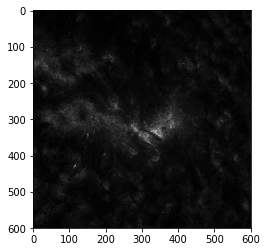

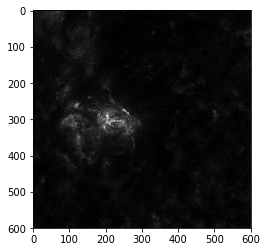

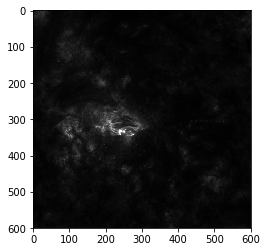

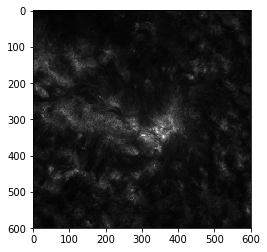

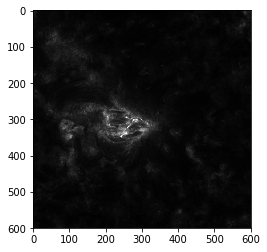

In [114]:
#dummy check to make sure images look ok
test=glob.glob('/home/zenalisa/data/fixed_aia/*/*/*/*.tiff')
print(test)
for t in test[:5]:
    plt.figure()
    plt.imshow(np.array(Image.open(t)), cmap='gray')

In [51]:
test_lists=[#'/home/zenalisa/data/test_list_10ar_210302.csv',
            
           # '/home/zenalisa/data/test_list_50ar_210128.csv', 
           # '/home/zenalisa/data/test_list_50ar_210128_new.csv',
            
           # '/home/zenalisa/data/test_list_50ar_210128_log10.csv',
           # '/home/zenalisa/data/test_list_50ar_210128_new_log10.csv',
            
           # '/home/zenalisa/data/test_list_50ar_210128_abs.csv',
           # '/home/zenalisa/data/test_list_50ar_210128_new_abs.csv',
            
           # '/home/zenalisa/data/test_list_50ar_210128_log10_abs.csv',
           # '/home/zenalisa/data/test_list_50ar_210128_new_log10_abs.csv',
            
            #'/home/zenalisa/data/rotate_lists/test_list_50ar_210128_log10_rotate.csv',
            #'/home/zenalisa/data/rotate_lists/test_list_50ar_210128_new_log10_rotate.csv',
            
            '/home/zenalisa/data/rotate_lists/test_list_50ar_210128_rotate.csv',
            '/home/zenalisa/data/rotate_lists/test_list_50ar_210128_new_rotate.csv',
            
            #'/home/zenalisa/data/test_list_1hem_210318log10.csv',
            #'/home/zenalisa/data/test_list_1hem_210318log10_new.csv',
            #'/home/zenalisa/data/test_list_south_only_log10.csv',
            
            #'/home/zenalisa/data/test_list_1hem_210318neither.csv',
            #'/home/zenalisa/data/test_list_1hem_210318neither_new.csv',
            #'/home/zenalisa/data/test_list_south_only_neither.csv',    
            ]


log_flag=[#True, True,
          False, False,
          #True, True,
          #False, False,
          #True, True,
          #True, True,
          #False, False, 
          #True, True, True,
          #False, False, False    
          ]


for t in test_lists:
    print(t)
    fix_aia(t, log_flag[test_lists.index(t)], rotate_flag=True)
    
 

  0%|          | 2/500 [00:00<00:48, 10.32it/s]

/home/zenalisa/data/rotate_lists/test_list_50ar_210128_rotate.csv


  0%|          | 2/555 [00:00<00:53, 10.39it/s]

/home/zenalisa/data/rotate_lists/test_list_50ar_210128_new_rotate.csv


100%|██████████| 555/555 [01:49<00:00,  5.07it/s]


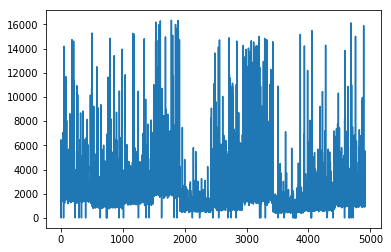

In [18]:
plt.plot(range(len(maxlist)), maxlist)

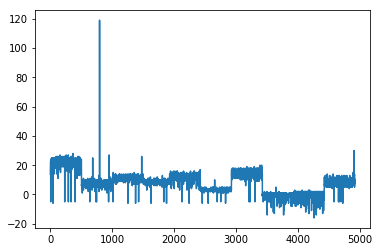

In [19]:
plt.plot(range(len(minlist)), minlist)

So, 1-ish seems like a good min. avoids too much clipping and any issues with log(0).
For max, ... I'm not sure. 2500 as mentioned by Dr. B seems way too low to me, I'd pick like, 10,000 probably

In [27]:
mx=0
mn=100000
maxlist=[]
minlist=[]
stdlist=[]

trainlist='/home/zenalisa/data/train_list_50ar_210128_log10_abs.csv'
trainlist=open(trainlist, 'r')
    

for l in tqdm(trainlist.readlines()):

        if 'path_signal' in l:
            continue
        tiffname=l.split(',')[0].strip()
        try:
            hminame=l.split(',')[1].strip()
        except IndexError:
            continue #if last line got cut off
        tiffdir='/'.join(tiffname.split('/')[:-2])

        fitsname=tiffname.replace(tiffdir, '/mnt/zena/AIA').replace('.tiff', '.fits')

        #this block is for if you're saving/plotting minlist and maxlist, but if not, runs much faster without the extra fits stuff
        #try:
        #    fits_img = fits.open(fitsname)
        #except IOError:
        #    continue #if the last line got cut off
        #break
        #fits_img.verify('fix') 
        #fits_data=fits_img[1].data    
        

        #maxlist.append(fits_data.max())
        #minlist.append(fits_data.min())
        #stdlist.append(np.std(fits_data))
        
        new_tiffdir=tiffdir.replace('/fs1/project/iip/zenalisa/data/', '/home/zenalisa/data/fixed_aia/')
        new_tiffname=tiffname.replace(tiffdir, new_tiffdir)
        a, amin, amax = fits_to_tiff(fitsname, 'aia', outp_name=new_tiffname, log_10=True)
        break

newtiffimg=np.array(Image.open(new_tiffname))

        

  0%|          | 1/5082 [00:00<13:05,  6.47it/s]


IOError: [Errno 21] Is a directory: '/home/zenalisa/data/fixed_aia/50ar_210128/aia_log/1156/aia.lev1_euv_12s.2011-02-12T192326Z.304.image.tiff'

In [8]:
print(np.mean(np.array(maxlist)))
print(np.mean(np.array(stdlist)))



2205.849242275143
69.08070782968692


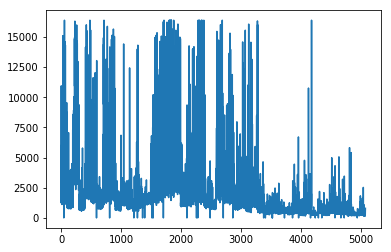

In [13]:
plt.plot(range(len(maxlist)), maxlist)

In [19]:
clip=0
for m in maxlist:
    if m>2650:
        clip+=1
        
print(float(clip)/float(len(maxlist)))

0.220232237748


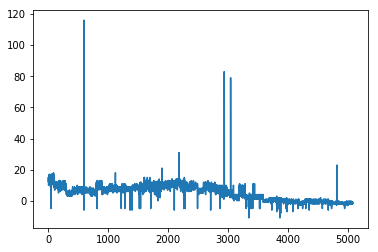

In [20]:
plt.plot(range(len(minlist)), minlist)

In [22]:
print(min(minlist))

-11
